In [2]:
import dgl
import numpy as np
import torch
import networkx as nx

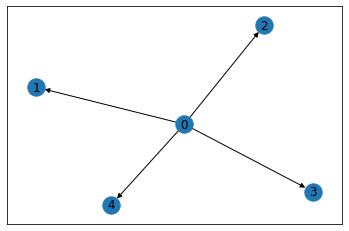

In [3]:
g = dgl.graph(([0,0,0,0], [1,2,3,4]), num_nodes=5)

gx = dgl.to_networkx(g)
nx.draw_networkx(gx)


In [4]:
g.ndata['value']  = torch.randn(5,3) #3d feature for node
g.edata['weight'] = torch.randn(4,4) #4d feature for edges

print(g.edata['weight']) # 4 edge -> 4 righe
print(g.ndata['value'])  # 5 nodi -> 5 righe


tensor([[ 0.6349,  2.0206,  1.5006,  1.4836],
        [-0.2376,  0.8563, -0.8796, -2.1299],
        [-1.2979, -1.0921, -0.8546,  0.5340],
        [ 1.5811,  0.5166,  1.4698, -0.3422]])
tensor([[ 0.0783,  0.1174, -0.6187],
        [ 1.8622, -0.5852, -0.0490],
        [ 0.5522, -1.0108,  0.8138],
        [ 0.5858,  1.8266, -1.7334],
        [ 2.3244,  2.1878,  0.4163]])


DGL graph


In [5]:
G = dgl.DGLGraph()
G.add_nodes(3)
G.add_edges([1,2,3],1)
G

C:\Users\Pietro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\dgl\heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


Graph(num_nodes=4, num_edges=3,
      ndata_schemes={}
      edata_schemes={})

In [6]:
graph = dgl.DGLGraph()

n = 10 # number of particles per jet
g.add_nodes(n)

src = []
dst = []
for i in range(n):
    for j in range(n):
        src.append(i)
        dst.append(j)

graph.add_edges(src, dst)


In [7]:
print(graph.num_nodes())
print(graph.num_edges())

10
100


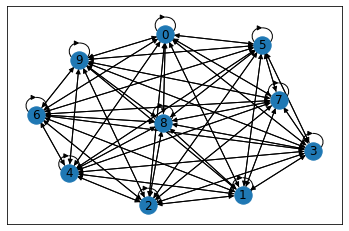

In [8]:
gx = dgl.to_networkx(graph)
nx.draw_networkx(gx)

In [9]:
node_feat = torch.randn(n,3)
graph.ndata['feat'] = node_feat
graph.ndata

{'feat': tensor([[ 0.2452,  0.9703,  0.4227],
        [-0.2426,  0.1229,  1.2778],
        [-2.2061,  1.1061, -0.4149],
        [ 0.7532, -1.0933, -0.1916],
        [-0.1301, -0.5850,  0.6753],
        [ 1.0344,  0.0499,  0.0361],
        [-0.6996,  2.4911, -0.8374],
        [ 0.9640,  1.0987,  0.8857],
        [-1.7987, -0.4335,  1.2680],
        [-1.6131,  0.2591, -0.6131]])}

In [10]:
edge_feat = torch.randn(n**2, 3)
print(edge_feat.shape)

graph.edata['edge_feat'] = edge_feat
# graph.edata

torch.Size([100, 3])


In [11]:
def build_graph(jet):
    """return a fully connected graph: 
        - n nodes -> n particles
        - n**2 edges -> each p is connected to all the others"""
    g = dgl.DGLGraph()
    n = len(jet)
    g.add_nodes(n)
    
    src = []; dst = []
    for i in range(n):
        for j in range(n):
            src.append(i)
            dst.append(j)

    graph.add_edges(src, dst)

    node_feat = jet # should be a tensor of shape [n, 5] where 5 are the features of each particle
    edge_feat = jet*jet # should be tensor of shape [n**2, 6 ]
    # the first n rows refer to the edges between the first particle and the other n ones

    graph.ndata['feat'] = node_feat
    graph.edata['edge_feat'] = edge_feat

    return g



## Decoder

In [12]:
from torch import nn
from dgl.nn import NNConv, EdgeConv

In [13]:
def MLP(efeat, ch=[256,128,64,32]):

    mlp = nn.Sequential(
        nn.Linear(len(efeat), ch[0]),
        nn.Dropout(0.2),
        nn.ReLU(),
        
        nn.Linear(ch[0],ch[1]),
        nn.Dropout(0.2),
        nn.ReLU(),
        
        nn.Linear(ch[1],ch[2]),
        nn.Dropout(0.2),
        nn.ReLU(),

        nn.Linear(ch[2], ch[3]),
        nn.Dropout(0.2),
        nn.Sigmoid()
    )
    
    return mlp(efeat)

In [14]:
class Encoder(nn.Module):
    
    def __init__(self, graph, latent_space_dim):
        super().__init__()
        
        self.conv = nn.Sequential(
            NNConv(
                in_feats = 7,  # number of node features
                out_fat = 128, # output number of node features
                edge_func = MLP),
            EdgeConv(128, 64),
            EdgeConv(64, 32),
            EdgeConv(32, latent_space_dim)
        )

    def forward(self, graph):
        x = self.conv(graph, graph.ndata, graph.edata)
        return x
    

In [27]:
class Decoder(nn.Module):
    
    def __init__(self, graph, latent_space_dim):
        super().__init__()
        
        self.node_reconstruct = nn.Sequential(
            EdgeConv(latent_space_dim, 32),
            EdgeConv(32, 64),
            EdgeConv(64, 128),
            EdgeConv(128, 7))# output are the reconstructed node features

        self.edge_reconstruct = nn.Sequential(
            EdgeConv(latent_space_dim, 32),
            EdgeConv(32, 64),
            EdgeConv(64, 128),
            EdgeConv(128, 32),
            EdgeConv(32,16),
            EdgeConv(16,8)
        )

    def forward(self, graph):
        # node reconstruction
        n = self.node_reconstruct(graph, graph.ndata, graph.edata)
        
        # edges reconstruction
        e1 = self.edge_reconstruct(graph, graph.ndata, graph.edata)
        e2 = self.edge_reconstruct(graph, graph.ndata, graph.edata)
        e3 = self.edge_reconstruct(graph, graph.ndata, graph.edata)

        # inner product
        e1 = torch.inner(e1,e1)  #their elements are A_{ij}
        e2 = torch.inner(e2, e2) 
        e3 = torch.inner(e3, e3)

        return n, e1, e2, e3
    

In [33]:
import torch

matrix1 = torch.tensor([[1, 2], [3, 4]])

result = torch.matmul(matrix1, matrix1)
result

tensor([[ 7, 10],
        [15, 22]])

In [34]:
torch.inner(matrix1,matrix1)

tensor([[ 5, 11],
        [11, 25]])